In [9]:
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [54]:
DATA_PATH = "/Users/rr/Desktop/Capstone_Project/Notebooks/data_40.json"

In [55]:
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

In [56]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2,figsize=(20,8))

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.show()

In [57]:
def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [58]:
def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [59]:
def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))


In [60]:
# get train, validation, test splits

X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

In [61]:
# create network

input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

In [62]:
# compile model

optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 63, 38, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 19, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 19, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 17, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 9, 32)         0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 15, 9, 32)         128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 8, 32)        

In [66]:
# train model

history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=100)

Epoch 1/100
79/79 [==============================] - 1s 16ms/step - loss: 0.0126 - accuracy: 0.9976 - val_loss: 0.0876 - val_accuracy: 0.9696
Epoch 2/100
79/79 [==============================] - 1s 15ms/step - loss: 0.0106 - accuracy: 0.9984 - val_loss: 0.0720 - val_accuracy: 0.9712
Epoch 3/100
79/79 [==============================] - 1s 15ms/step - loss: 0.0123 - accuracy: 0.9964 - val_loss: 0.0775 - val_accuracy: 0.9712
Epoch 4/100
79/79 [==============================] - 1s 16ms/step - loss: 0.0126 - accuracy: 0.9980 - val_loss: 0.0679 - val_accuracy: 0.9712
Epoch 5/100
79/79 [==============================] - 1s 15ms/step - loss: 0.0118 - accuracy: 0.9976 - val_loss: 0.0941 - val_accuracy: 0.9696
Epoch 6/100
79/79 [==============================] - 1s 15ms/step - loss: 0.0093 - accuracy: 0.9984 - val_loss: 0.0694 - val_accuracy: 0.9712
Epoch 7/100
79/79 [==============================] - 1s 16ms/step - loss: 0.0100 - accuracy: 0.9984 - val_loss: 0.0791 - val_accuracy: 0.9696
Epoch 

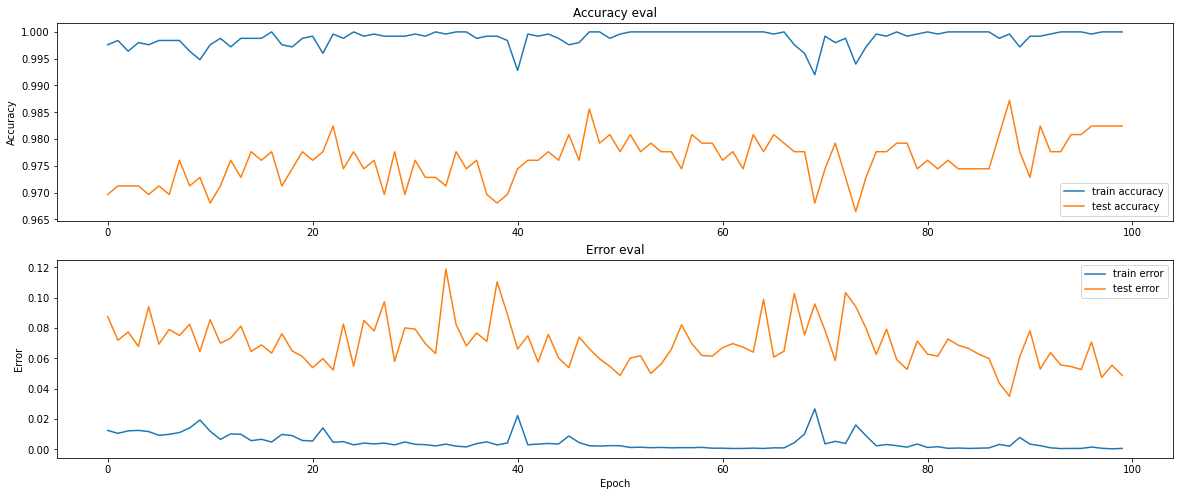

In [67]:
# plot accuracy/error for training and validation

plot_history(history)

In [68]:
# evaluate model on test set

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

33/33 - 0s - loss: 0.1350 - accuracy: 0.9732

Test accuracy: 0.9731543660163879


0 = Fixed-wing
1 = Helicopter

In [61]:
# pick a sample to predict from the test set

X_to_predict = X_test[5]
y_to_predict = y_test[5]

# predict sample
predict(model, X_to_predict, y_to_predict)

Target: 0, Predicted label: [0]


In [63]:
y_test[5]

0

# GridSearch Pipeline (to-do)

In [39]:
# build network topology
cnn_model = keras.Sequential()

    # 1st conv layer
cnn_model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
cnn_model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
cnn_model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
cnn_model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
cnn_model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
cnn_model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
cnn_model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
cnn_model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
cnn_model.add(keras.layers.Flatten())
cnn_model.add(keras.layers.Dense(64, activation='relu'))
cnn_model.add(keras.layers.Dropout(0.3))

    # output layer
cnn_model.add(keras.layers.Dense(10, activation='softmax'))

optimiser = keras.optimizers.Adam(learning_rate=0.0001)
cnn_model.compile(optimizer=optimiser,
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

cnn_model.summary()

   

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 63, 11, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 6, 32)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 6, 32)         128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 2, 32)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 2, 32)         128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 1, 32)        

In [32]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.wrappers.scikit_learn import KerasClassifier

In [52]:
# define the grid search parameters

batch_size = [100]
epochs = [25, 40, 55, 70]
#num_mfcc = [13, 25, 40, 55]
#n_fft = [2048]
#hop_length = [512]

param_grid = dict(batch_size=batch_size, epochs=epochs)

scorers = {'precision_score': make_scorer(precision_score),
'recall_score': make_scorer(recall_score),
'accuracy_score': make_scorer(accuracy_score)
}

estimator = cnn_model

grid = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=1, cv=3, scoring=scorers,refit="precision_score")





In [18]:
X = X_train
Y = y_train

In [53]:
grid_result = grid.fit(X, Y)

TypeError: Cannot clone object '<keras.engine.sequential.Sequential object at 0x290284910>' (type <class 'keras.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))